In [1]:
import math
import os
import torch
import torch.distributions.constraints as constraints
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import pyro.distributions as dist
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import torch
from torch.utils.data import DataLoader, TensorDataset
import lightning as L
import torch.nn.functional as F
import optuna
import tensorboard
from lightning.pytorch.loggers import TensorBoardLogger

import warnings
warnings.filterwarnings("ignore")
from importlib import reload

import torchclustermetrics 
reload(torchclustermetrics)
from torchclustermetrics import silhouette

# this ensures that I can update the class without losing my variables in my notebook
import xenium_cluster
reload(xenium_cluster)
from xenium_cluster import XeniumCluster
from utils.metrics import *

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


from sklearn.cluster import KMeans;

In [2]:
# Path to your .gz file
file_path = 'data/hBreast/transcripts.csv.gz'

# Read the gzipped CSV file into a DataFrame
df_transcripts = pd.read_csv(file_path, compression='gzip')
df_transcripts["error_prob"] = 10 ** (-df_transcripts["qv"]/10)
df_transcripts.head(), df_transcripts.shape

(     transcript_id  cell_id  overlaps_nucleus feature_name  x_location  \
 0  281474976710657   191815                 1          LUM   4797.2383   
 1  281474976710663   214084                 1       SEC11C   4801.7330   
 2  281474976710672   191342                 0         TCIM   4804.4920   
 3  281474976710673   191574                 0         STC1   4805.0483   
 4  281474976710674   192193                 0         STC1   4805.7170   
 
    y_location  z_location         qv  error_prob  
 0   550.61346   15.421524  18.445875    0.014303  
 1   905.11600   14.925031  31.019386    0.000791  
 2   596.05396   14.681485  22.270780    0.005928  
 3   414.38370   19.306356  16.183300    0.024081  
 4   273.81440   16.112896  26.251837    0.002370  ,
 (43775350, 9))

In [3]:
# drop cells without ids
df_transcripts = df_transcripts[df_transcripts["cell_id"] != -1]

In [4]:
sum(df_transcripts["error_prob"] > 0.25)

22

In [5]:
clustering = XeniumCluster(data=df_transcripts, dataset_name="hBreast")
clustering.set_spot_size(55)
clustering.create_spot_data(third_dim=False, save_data=True)

In [6]:
clustering.xenium_spot_data.X.shape

(19559, 541)

In [7]:
valid_genes_mask = ~clustering.xenium_spot_data.var_names.str.startswith('BLANK_') & ~clustering.xenium_spot_data.var_names.str.startswith('NegControl')
clustering.xenium_spot_data = clustering.xenium_spot_data[:, valid_genes_mask]

In [8]:
clustering.normalize_counts(clustering.xenium_spot_data)

In [9]:
clustering.filter_only_high_variable_genes(clustering.xenium_spot_data, flavor="seurat", min_mean=0.0125, max_mean=1000, min_disp=1.0)

In [10]:
clustering.xenium_spot_data = clustering.xenium_spot_data[:,clustering.xenium_spot_data.var.highly_variable==True]
clustering.xenium_spot_data.var.shape

(42, 4)

In [11]:
sc.tl.pca(clustering.xenium_spot_data, svd_solver='arpack', n_comps=5)
clustering.xenium_spot_data.obsm["X_pca"].shape

(19559, 5)

In [12]:
NUM_CLUSTERS = 16
BATCH_SIZE = 16

# Clear the param store in case we're in a REPL
pyro.clear_param_store()

In [13]:
spatial_pca = np.concatenate((clustering.xenium_spot_data.obs[["x_location", "y_location"]], clustering.xenium_spot_data.obsm["X_pca"]), axis=1)
spatial_pca = StandardScaler().fit_transform(spatial_pca)

In [14]:
kmeans = KMeans(n_clusters=NUM_CLUSTERS).fit(spatial_pca)

In [15]:
kmeans_initial_clusters = kmeans.predict(spatial_pca)

In [16]:
rows = clustering.xenium_spot_data.obs["row"].astype(int)
columns = clustering.xenium_spot_data.obs["col"].astype(int)

num_rows = int(max(rows) - min(rows) + 1)
num_cols = int(max(columns) - min(columns) + 1)

In [17]:
cluster_grid = torch.zeros((num_rows, num_cols), dtype=torch.long)

cluster_grid[rows, columns] = torch.tensor(kmeans_initial_clusters.astype(int)) + 1

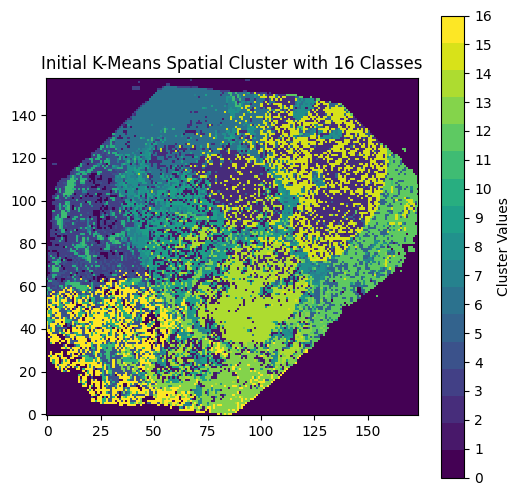

In [18]:
colors = plt.cm.get_cmap('viridis', NUM_CLUSTERS + 1)
colormap = ListedColormap(colors(np.linspace(0, 1, NUM_CLUSTERS + 1)))

# Plotting
plt.figure(figsize=(6, 6))
plt.imshow(cluster_grid, cmap=colormap, interpolation='nearest', origin='lower')
plt.colorbar(ticks=range(NUM_CLUSTERS + 1), label='Cluster Values')
plt.title(f'Initial K-Means Spatial Cluster with {NUM_CLUSTERS} Classes')
plt.show()

In [19]:
concentration_priors = torch.tensor(pd.get_dummies(kmeans_initial_clusters, dtype=float).to_numpy())
concentration_w_locations = torch.cat((torch.tensor(clustering.xenium_spot_data.obs[["row", "col"]].to_numpy()), concentration_priors), dim=1)
concentration_w_locations

tensor([[ 39.,   0.,   0.,  ...,   0.,   0.,   1.],
        [ 40.,   0.,   0.,  ...,   0.,   0.,   1.],
        [ 41.,   0.,   0.,  ...,   0.,   0.,   1.],
        ...,
        [104., 173.,   0.,  ...,   0.,   0.,   0.],
        [106., 173.,   0.,  ...,   0.,   0.,   0.],
        [107., 173.,   0.,  ...,   0.,   0.,   0.]], dtype=torch.float64)

In [20]:
concentration_w_locations.shape

torch.Size([19559, 18])

In [21]:
spatial_concentration_priors = concentration_priors.clone()
NEIGHBORHOOD_SIZE = 2
for concentration, spatial_concentration in zip(concentration_w_locations, spatial_concentration_priors):
    row, col = concentration[:2]
    
    # Apply the conditions for neighborhood
    is_row_near = (concentration_w_locations[:, 0] >= (row - NEIGHBORHOOD_SIZE)) & (concentration_w_locations[:, 0] <= (row + NEIGHBORHOOD_SIZE))
    is_col_near = (concentration_w_locations[:, 1] >= (col - NEIGHBORHOOD_SIZE)) & (concentration_w_locations[:, 1] <= (col + NEIGHBORHOOD_SIZE))
    
    # Combine the row and column conditions
    neighborhood_mask = is_row_near & is_col_near
    
    # Select the neighborhood based on the mask
    neighborhood = concentration_priors[neighborhood_mask]
    
    # Compute the mean of the data columns in the neighborhood
    mean_values = neighborhood.sum(dim=0)
    
    # Assign the mean back to the corresponding locations in the original tensor (modify this as needed)
    spatial_concentration += mean_values

In [22]:
CONCENTRATION_AMPLIFICATION = 5
print(concentration_priors)
concentration_priors = spatial_concentration_priors
print(concentration_priors)
concentration_priors += torch.distributions.half_normal.HalfNormal(0.1).sample((concentration_priors.shape))
print(concentration_priors)
concentration_priors *= CONCENTRATION_AMPLIFICATION
torch.round(concentration_priors, decimals=4)

tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)
tensor([[ 0.,  0.,  0.,  ...,  0.,  0.,  9.],
        [ 0.,  0.,  0.,  ...,  0.,  0., 10.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  9.],
        ...,
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]], dtype=torch.float64)
tensor([[2.7315e-01, 5.2716e-02, 1.6076e-02,  ..., 1.4696e-01, 2.3809e-02,
         9.0395e+00],
        [1.8105e-01, 1.2282e-01, 1.9023e-02,  ..., 2.4006e-02, 7.2197e-02,
         1.0005e+01],
        [1.2150e-01, 7.8700e-02, 3.0596e-02,  ..., 1.7885e-01, 3.1444e-02,
         9.1220e+00],
        ...,
        [1.9940e-01, 4.2228e-02, 2.5304e-02,  ..., 9.0848e-02, 1.6100e-02,
         1.2050e-01],
        [1.74

tensor([[1.3657e+00, 2.6360e-01, 8.0400e-02,  ..., 7.3480e-01, 1.1900e-01,
         4.5198e+01],
        [9.0520e-01, 6.1410e-01, 9.5100e-02,  ..., 1.2000e-01, 3.6100e-01,
         5.0025e+01],
        [6.0750e-01, 3.9350e-01, 1.5300e-01,  ..., 8.9420e-01, 1.5720e-01,
         4.5610e+01],
        ...,
        [9.9700e-01, 2.1110e-01, 1.2650e-01,  ..., 4.5420e-01, 8.0500e-02,
         6.0250e-01],
        [8.7400e-02, 4.3600e-02, 1.3420e+00,  ..., 6.5290e-01, 2.6500e-01,
         1.0189e+00],
        [5.0010e-01, 2.3210e-01, 2.1440e-01,  ..., 6.3220e-01, 3.3490e-01,
         1.0000e-01]], dtype=torch.float64)

In [23]:
# Load the data (5 PCs for each spot)
data = torch.tensor(clustering.xenium_spot_data.obsm["X_pca"]).float()

In [24]:
def model(data):
    # Define priors for the cluster assignment probabilities and Gaussian parameters
    with pyro.plate("data", len(data), subsample_size=BATCH_SIZE) as ind:
        batch_data = data[ind]
        batch_concentration_priors = concentration_priors[ind]
        cluster_probs = pyro.sample("cluster_probs", dist.Dirichlet(batch_concentration_priors))
        
        # Define the means and variances of the Gaussian components
        cluster_means = pyro.sample("cluster_means", dist.Normal(0., 1.).expand([NUM_CLUSTERS, batch_data.size(1)]).to_event(2))
        cluster_scales = pyro.sample("cluster_scales", dist.LogNormal(0., 1.).expand([NUM_CLUSTERS, batch_data.size(1)]).to_event(2))
        
        # Likelihood of data given cluster assignments
        pyro.sample("obs", dist.MixtureOfDiagNormals(cluster_means, cluster_scales, cluster_probs).to_event(1), obs=batch_data)

def guide(data):
    MIN_CONCENTRATION = 0.1
    # Initialize cluster assignment probabilities for the entire dataset
    cluster_concentration_params_q = pyro.param("cluster_concentration_params_q", concentration_priors, constraint=dist.constraints.positive) + MIN_CONCENTRATION
    # Global variational parameters for means and scales
    cluster_means_q = pyro.param("cluster_means_q", torch.randn(NUM_CLUSTERS, data.size(1)))
    cluster_scales_q = pyro.param("cluster_scales_q", torch.ones(NUM_CLUSTERS, data.size(1)), constraint=dist.constraints.positive)
    
    with pyro.plate("data", len(data), subsample_size=BATCH_SIZE) as ind:

        batch_cluster_concentration_params_q = cluster_concentration_params_q[ind]

        # pyro.sample("cluster_assignments", dist.Categorical(batch_cluster_probs_q))
        pyro.sample("cluster_probs", dist.Dirichlet(batch_cluster_concentration_params_q))
        pyro.sample("cluster_means", dist.Normal(cluster_means_q, 0.1).to_event(2))
        pyro.sample("cluster_scales", dist.LogNormal(cluster_scales_q, 0.1).to_event(2))

In [25]:
from pyro.optim import PyroOptim, PyroLRScheduler
from torch.optim import Adam, SGD, lr_scheduler

starting_lr = 0.01
ending_lr = 0.00001
N_STEPS = 10000

# Setup the optimizer
adam_params = {"lr": 0.001, "betas": (0.90, 0.999)}
scheduler = PyroOptim(Adam, adam_params)
# scheduler = PyroLRScheduler(lr_scheduler.StepLR, {'optimizer': Adam, 'optim_args': {'lr': starting_lr, "betas": (0.90, 0.999)}, 'step_size': 1, 'gamma': (ending_lr / starting_lr) ** (1 / N_STEPS)})
# scheduler = PyroLRScheduler(lr_scheduler.StepLR, {'optimizer': SGD, 'optim_args': {'lr': starting_lr}, 'step_size': 1, 'gamma': (ending_lr / starting_lr) ** (1 / N_STEPS)})

In [26]:
# Setup the inference algorithm
svi = SVI(model, guide, scheduler, loss=Trace_ELBO(num_particles=10))

In [27]:
for step in range(N_STEPS):
    loss = svi.step(data)
    # svi.optim.step()
    if step % 100 == 0:
        print(f"Step {step} : loss = {round(loss/1e6, 4)}")

Step 0 : loss = 10.7557
Step 100 : loss = 10.4487
Step 200 : loss = 10.2245
Step 300 : loss = 10.0207
Step 400 : loss = 9.8442
Step 500 : loss = 9.8647
Step 600 : loss = 9.6477
Step 700 : loss = 9.6881
Step 800 : loss = 9.5676
Step 900 : loss = 9.3942
Step 1000 : loss = 9.5074
Step 1100 : loss = 9.4272
Step 1200 : loss = 9.3918
Step 1300 : loss = 9.4492
Step 1400 : loss = 9.3431
Step 1500 : loss = 9.2949
Step 1600 : loss = 9.2421
Step 1700 : loss = 9.3815
Step 1800 : loss = 9.4226
Step 1900 : loss = 9.2527
Step 2000 : loss = 9.2744
Step 2100 : loss = 9.2442
Step 2200 : loss = 9.3055
Step 2300 : loss = 9.3692
Step 2400 : loss = 9.2702
Step 2500 : loss = 9.2158
Step 2600 : loss = 9.4041
Step 2700 : loss = 9.212
Step 2800 : loss = 9.2836
Step 2900 : loss = 9.2247
Step 3000 : loss = 9.3189
Step 3100 : loss = 9.2817
Step 3200 : loss = 9.2593
Step 3300 : loss = 9.1901
Step 3400 : loss = 9.227
Step 3500 : loss = 9.1599
Step 3600 : loss = 9.2639
Step 3700 : loss = 9.1953
Step 3800 : loss = 9.2

In [28]:
# Grab the learned variational parameters
cluster_concentration_params_q = pyro.param("cluster_concentration_params_q")
cluster_probs_q = pyro.sample("cluster_probs", dist.Dirichlet(cluster_concentration_params_q)).detach()
cluster_concentration_params_q = cluster_concentration_params_q.detach()

cluster_assignments_q = cluster_probs_q.argmax(dim=1)
cluster_means_q = pyro.param("cluster_means_q").detach()
cluster_scales_q = pyro.param("cluster_scales_q").detach()

# Output the learned cluster probabilities for each data point
print(cluster_assignments_q, torch.round(cluster_probs_q, decimals=4))

tensor([15, 15, 15,  ..., 11, 11, 11]) tensor([[1.8000e-03, 1.0000e-04, 0.0000e+00,  ..., 2.7100e-02, 8.0000e-04,
         7.1380e-01],
        [9.0000e-04, 1.2900e-02, 1.0000e-04,  ..., 1.2000e-03, 3.7000e-03,
         5.2990e-01],
        [3.1000e-03, 3.0000e-04, 0.0000e+00,  ..., 2.2000e-03, 0.0000e+00,
         5.0630e-01],
        ...,
        [2.9100e-02, 2.0000e-04, 2.8000e-03,  ..., 3.8000e-03, 0.0000e+00,
         1.9000e-03],
        [0.0000e+00, 1.2000e-03, 2.7100e-02,  ..., 2.3000e-03, 1.0500e-02,
         5.8000e-03],
        [0.0000e+00, 8.0000e-04, 2.0000e-03,  ..., 5.6000e-03, 3.0000e-04,
         2.7500e-02]], dtype=torch.float64)


(array([2950., 1559.,  937., 2243., 1007., 1769.,  335., 1559., 3368.,
        3832.]),
 array([ 0. ,  1.5,  3. ,  4.5,  6. ,  7.5,  9. , 10.5, 12. , 13.5, 15. ]),
 <BarContainer object of 10 artists>)

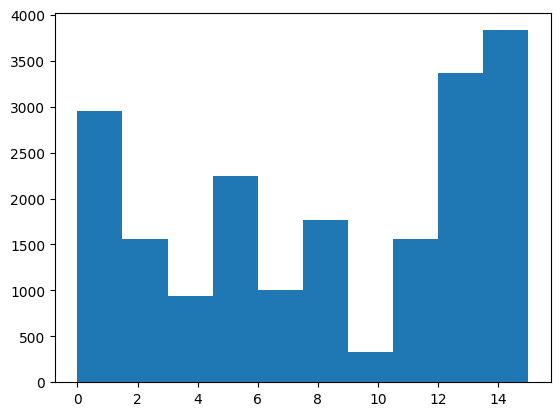

In [29]:
plt.hist(cluster_assignments_q)

In [30]:
np.set_printoptions(suppress=True) 
np.round(cluster_means_q, 4), np.round(cluster_scales_q, 4)

(tensor([[ 0.1732,  0.0341, -0.0084, -0.1219, -0.1001],
         [ 0.7181, -0.4710, -0.0069,  0.3360,  0.3232],
         [-0.2992, -0.2039, -0.0125, -0.0359, -0.1324],
         [ 0.3574,  0.5327,  0.2749,  0.2304,  0.2588],
         [ 0.1214,  0.0032, -0.0660, -0.1106, -0.0542],
         [ 0.1377,  0.1617, -0.0649, -0.3062, -0.1525],
         [ 0.1529, -0.0296, -0.0951, -0.0636, -0.0431],
         [ 0.1678,  0.0363, -0.0661, -0.0465, -0.0473],
         [ 0.1812,  0.0276, -0.0593, -0.1068, -0.1117],
         [-0.1584, -0.0097, -0.1065, -0.1338, -0.0606],
         [ 0.1579, -0.0445, -0.1017, -0.0637, -0.0458],
         [-0.1605,  0.0062, -0.1292, -0.1397, -0.0618],
         [ 0.1303,  0.1749,  0.0165, -0.1603, -0.0355],
         [ 0.5195, -0.2839,  0.0744,  0.2127,  0.1045],
         [ 0.1672, -0.0560, -0.0933, -0.1222, -0.0246],
         [-0.3307, -0.2752,  0.0426,  0.0071, -0.1740]]),
 tensor([[0.7105, 0.5996, 0.4750, 0.1464, 0.0320],
         [0.0286, 1.0025, 0.0314, 0.0165, 0.0149],


In [31]:
rows = clustering.xenium_spot_data.obs["row"].astype(int)
columns = clustering.xenium_spot_data.obs["col"].astype(int)

num_rows = int(max(rows) - min(rows) + 1)
num_cols = int(max(columns) - min(columns) + 1)

In [32]:
cluster_grid = torch.zeros((num_rows, num_cols), dtype=torch.long)

cluster_grid[rows, columns] = cluster_assignments_q + 1

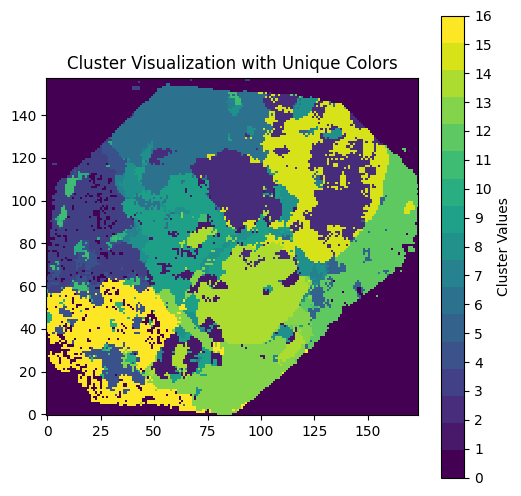

In [33]:
colors = plt.cm.get_cmap('viridis', NUM_CLUSTERS + 1)
colormap = ListedColormap(colors(np.linspace(0, 1, NUM_CLUSTERS + 1)))

# Plotting
plt.figure(figsize=(6, 6))
plt.imshow(cluster_grid, cmap=colormap, interpolation='nearest', origin='lower')
plt.colorbar(ticks=range(NUM_CLUSTERS + 1), label='Cluster Values')
plt.title('Cluster Visualization with Unique Colors')
plt.show()

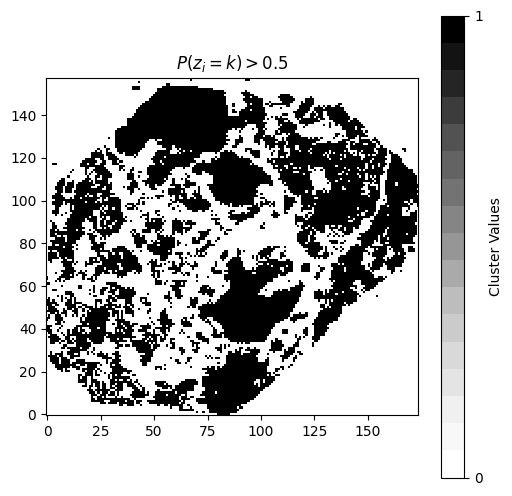

In [34]:
# confidence mapping
cluster_confidences = torch.zeros((num_rows, num_cols), dtype=torch.double)

cluster_confidences[rows, columns] = cluster_probs_q.max(dim=1).values

colors = plt.cm.get_cmap('Greys', NUM_CLUSTERS + 1)
colormap = ListedColormap(colors(np.linspace(0, 1, NUM_CLUSTERS + 1)))

# Plotting
plt.figure(figsize=(6, 6))
plt.imshow(cluster_confidences > 0.5, cmap=colormap, interpolation='nearest', origin='lower')
plt.colorbar(ticks=range(NUM_CLUSTERS + 1), label='Cluster Values')
plt.title(r'$P(z_i = k) > 0.5$')
plt.show()

In [40]:
# grab the WSS distance of cluster labels
wss = {}
for label in range(1, NUM_CLUSTERS + 1):
    current_cluster_locations = torch.stack(torch.where((cluster_grid == label)), axis=1).to(float)
    SPOT_SIZE = 55
    wss[f"Cluster {label}"] = SPOT_SIZE ** 2 * torch.mean(torch.cdist(current_cluster_locations, current_cluster_locations)).item()
wss

{'Cluster 1': 110949.99576275422,
 'Cluster 2': 113193.87336273084,
 'Cluster 3': 79702.39982697056,
 'Cluster 4': 121655.04727553196,
 'Cluster 5': 84738.444768219,
 'Cluster 6': 85735.6905773319,
 'Cluster 7': 197000.864966126,
 'Cluster 8': 170392.88791112916,
 'Cluster 9': 96251.67982660806,
 'Cluster 10': 109584.53831433796,
 'Cluster 11': 157849.6640445215,
 'Cluster 12': 91122.48391931059,
 'Cluster 13': 93304.52502509288,
 'Cluster 14': 80471.42349522052,
 'Cluster 15': 101134.2988789534,
 'Cluster 16': 92694.05548337428}

In [36]:
# identify marker genes within each cluster
mean_expression_by_cluster = pd.DataFrame(columns=clustering.xenium_spot_data.var.index)

for label in range(NUM_CLUSTERS):
    current_cluster_indexes = list(torch.where(cluster_assignments_q == label)[0])
    expressions = pd.DataFrame(clustering.xenium_spot_data.X, columns=clustering.xenium_spot_data.var.index).iloc[current_cluster_indexes, :]
    mean_expressions = expressions.mean(axis=0).to_frame().T
    mean_expression_by_cluster = pd.concat([mean_expression_by_cluster, mean_expressions], ignore_index=True)

In [37]:
mean_expression_by_cluster

,ACTA2,ADIPOQ,AQP1,BANK1,CAV1,CCDC80,CCL5,CCL8,CD3E,CD79A,...,POSTN,PTGDS,PTN,PTPRC,S100A8,SFRP1,SFRP4,TOP2A,TPSAB1,VWF
0,2.640297,0.294242,2.373941,0.266117,1.870075,1.605851,0.648099,0.251917,0.938770,0.095142,...,3.099635,0.839719,0.606064,1.952255,0.073783,0.324824,1.336104,1.288750,0.447413,1.806949
1,2.721522,0.421973,1.412630,0.398380,0.911079,0.674803,0.244017,0.182325,0.654555,0.045000,...,1.358729,0.396686,0.661929,1.787151,0.059885,0.225568,0.978390,1.641761,0.366195,0.892822
2,0.773207,0.077442,0.619802,0.127617,0.620915,1.550281,0.166755,0.163527,0.239696,0.100667,...,0.448388,0.484974,0.138962,0.485223,0.045356,0.730664,0.675407,0.042975,0.051517,0.493844
3,1.560400,0.182635,0.969117,0.179833,1.074865,2.643146,0.337076,0.269749,0.501689,0.188908,...,0.543054,1.305237,0.378350,0.920177,0.075135,1.944991,1.468020,0.135896,0.112285,0.681402
4,2.880761,0.358015,2.062185,0.253429,2.212497,2.510854,0.621403,0.356499,0.768662,0.372053,...,0.972428,0.756485,0.351422,1.356158,0.037878,1.134375,1.791128,0.314660,0.325936,1.708441
5,3.054645,0.307427,1.722359,0.320639,1.488449,1.977868,0.493047,0.215600,0.862523,0.161722,...,3.245464,0.341160,0.668817,2.035740,0.048173,0.663778,2.546292,1.336254,0.565332,1.342093
6,2.707845,0.731567,2.378657,1.468178,2.143515,3.081527,2.196695,0.612123,2.562584,1.045136,...,1.984108,2.079551,0.460084,3.200336,0.199221,1.210845,2.534070,0.588783,0.383576,2.034415
7,2.710547,0.305906,1.316697,0.533099,1.556925,2.803234,2.106196,0.469010,2.373914,0.623930,...,2.877602,0.954235,0.703342,2.949350,0.071250,1.076493,3.039186,0.592255,0.420082,0.947034
8,2.780298,0.252641,1.550138,0.274988,1.395128,1.803275,0.669834,0.208079,1.046029,0.172692,...,3.193869,0.543216,0.663644,2.056084,0.054055,0.474646,1.694822,1.057471,0.559547,1.055011
9,1.909015,0.101826,1.880263,0.291763,1.878414,2.606559,0.344011,0.505445,0.482574,0.196519,...,0.843626,1.188878,0.258698,1.009185,0.096066,1.341301,1.161761,0.140274,0.103630,1.761106


(0.5, 0.0, 1.0, 1.0)


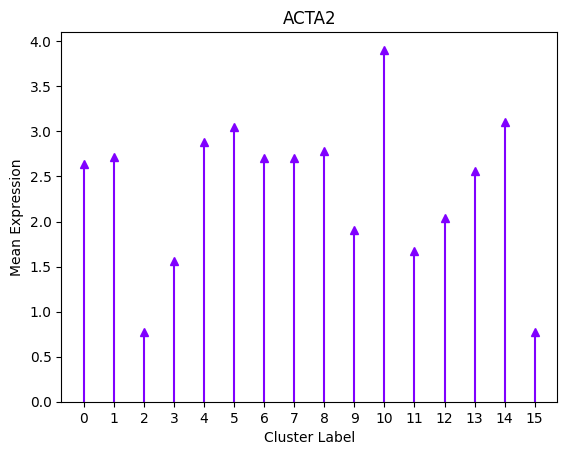

(0.45294117647058824, 0.07385252747487396, 0.9993170601430229, 1.0)


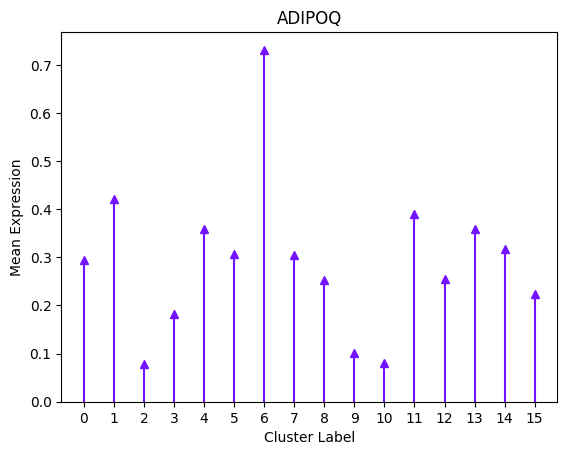

(0.40588235294117647, 0.1473016980546375, 0.997269173385788, 1.0)


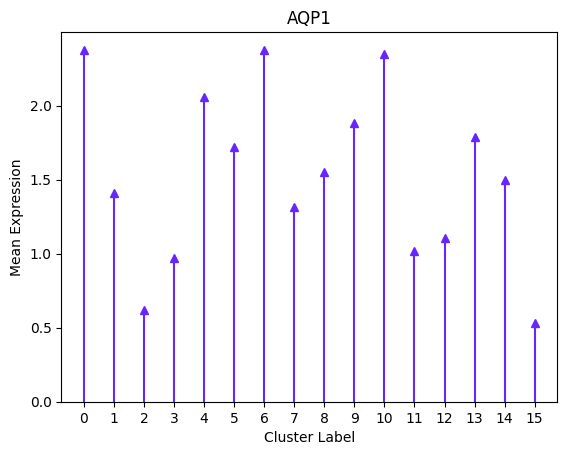

(0.3588235294117647, 0.2199463578396686, 0.9938591368952737, 1.0)


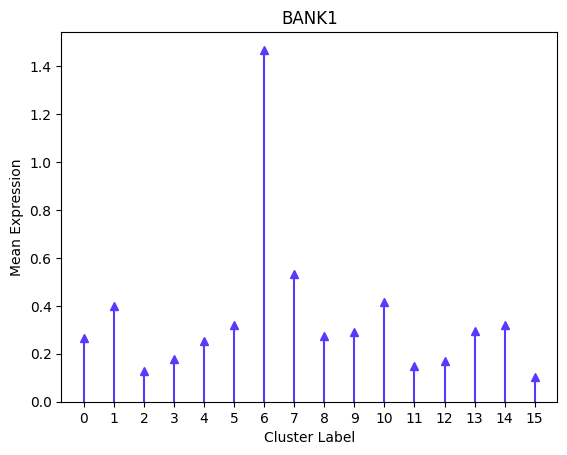

(0.31176470588235294, 0.2913897468893246, 0.989091608371146, 1.0)


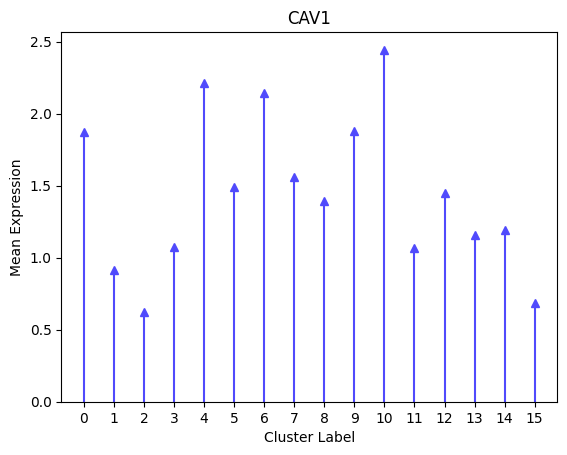

(0.2568627450980392, 0.37270199199091397, 0.9818225628535369, 1.0)


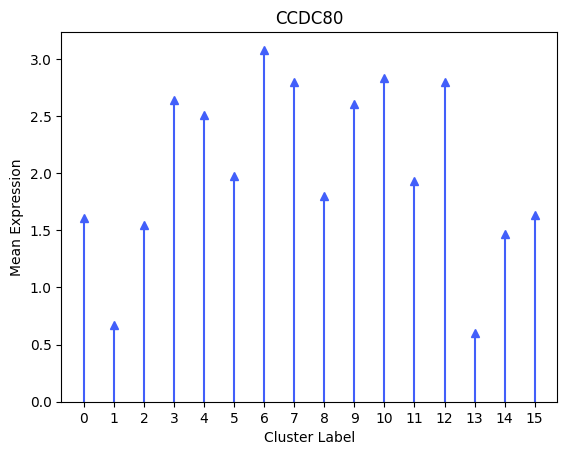

(0.20980392156862748, 0.44021574083098725, 0.9741386021045101, 1.0)


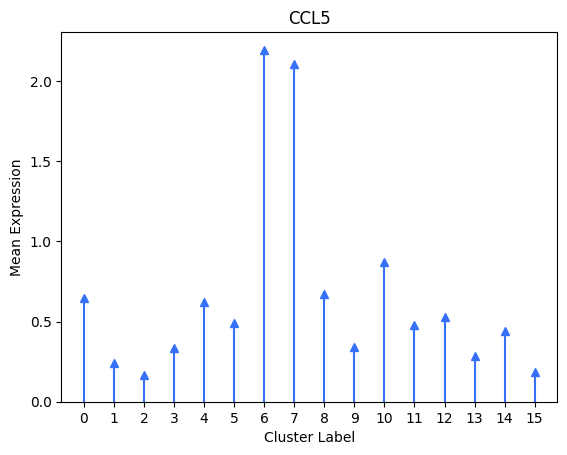

(0.16274509803921566, 0.5053251839489481, 0.965124085200289, 1.0)


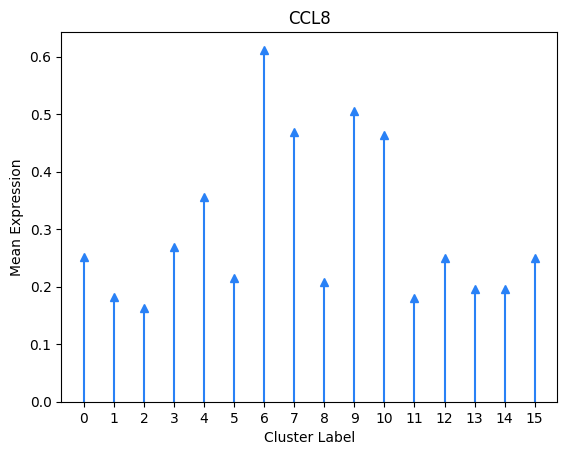

(0.11568627450980395, 0.5676747161445901, 0.9547913248866443, 1.0)


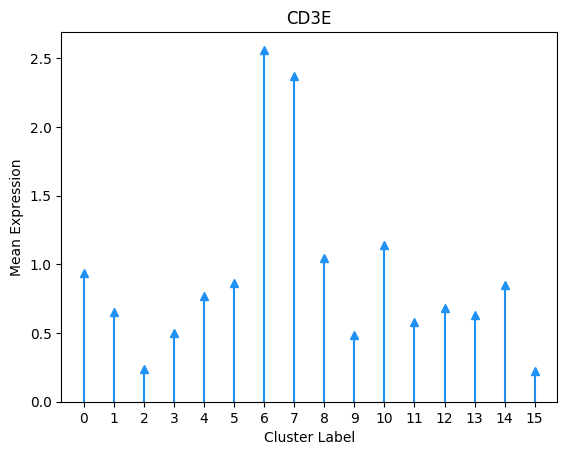

(0.0607843137254902, 0.6364742361471414, 0.9410892525013717, 1.0)


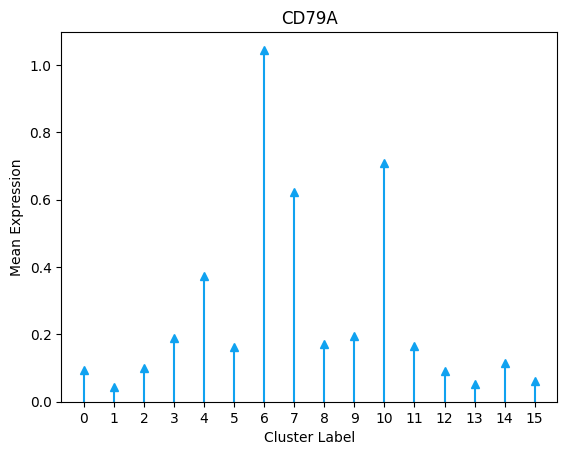

(0.013725490196078438, 0.6916984393193699, 0.9279510898565747, 1.0)


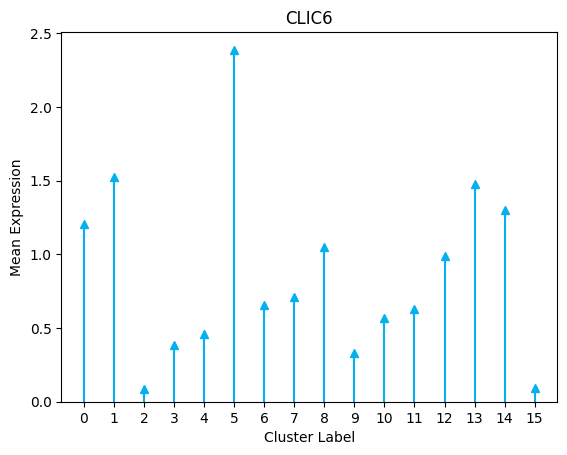

(0.033333333333333326, 0.7431448254773941, 0.9135454576426009, 1.0)


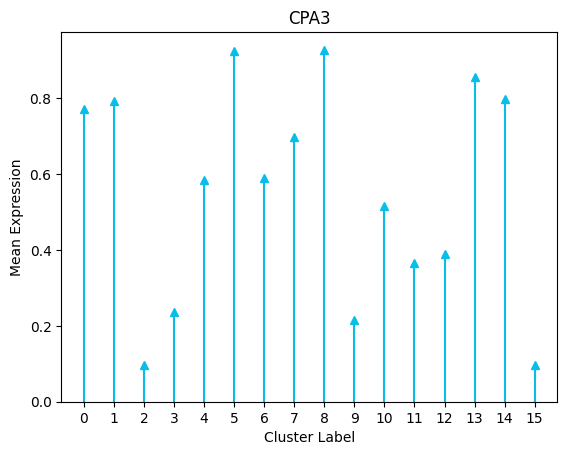

(0.08039215686274503, 0.7905324123001632, 0.8978920322202582, 1.0)


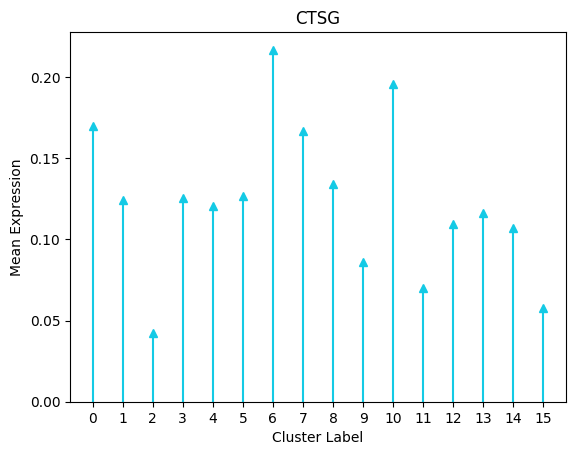

(0.1352941176470588, 0.8403440716378927, 0.8780812480836979, 1.0)


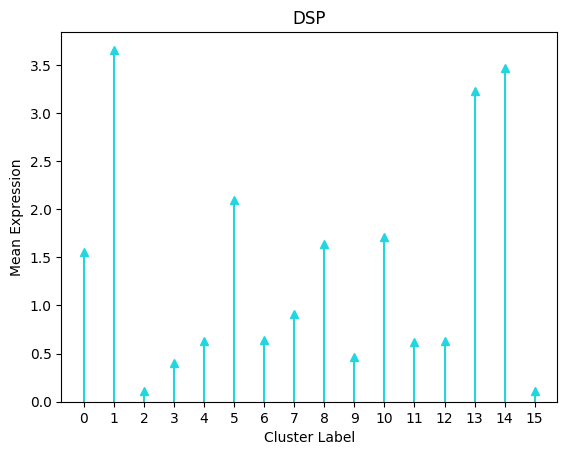

(0.1823529411764706, 0.8780812480836979, 0.8597998514483725, 1.0)


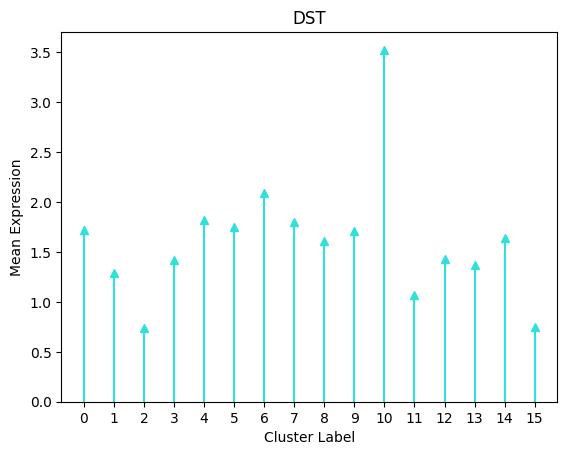

(0.22941176470588232, 0.9110226492460882, 0.8403440716378927, 1.0)


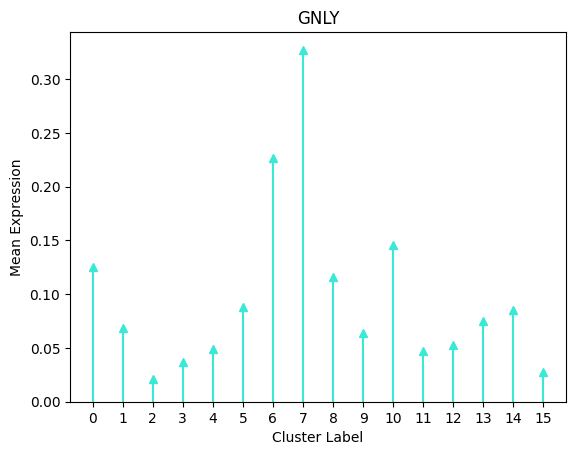

(0.27647058823529413, 0.9389883606150565, 0.8197404829072211, 1.0)


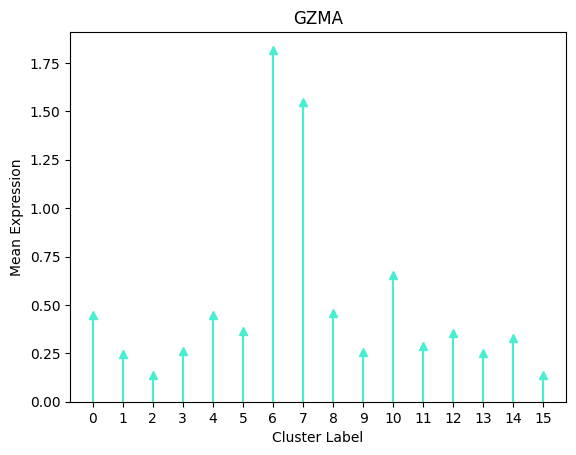

(0.3313725490196078, 0.965124085200289, 0.7942898895752861, 1.0)


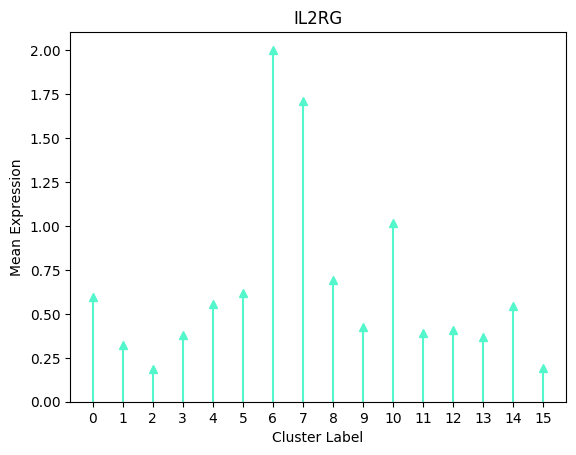

(0.3784313725490196, 0.9818225628535369, 0.7712979623471807, 1.0)


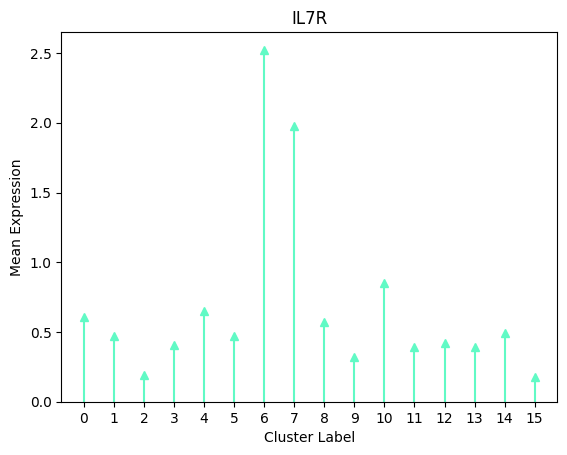

(0.4254901960784314, 0.9931586661366362, 0.747252534878891, 1.0)


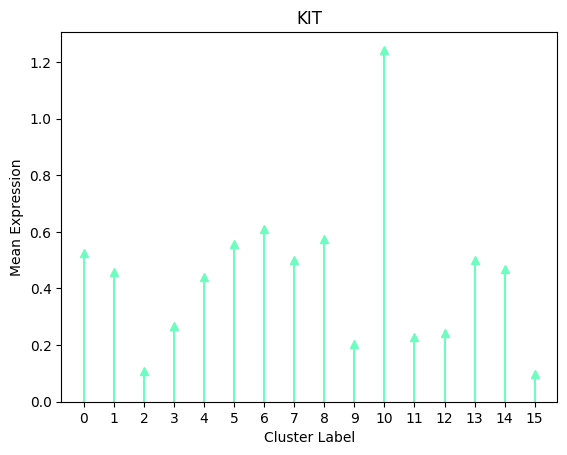

(0.4725490196078431, 0.9990704811844932, 0.7221864503320093, 1.0)


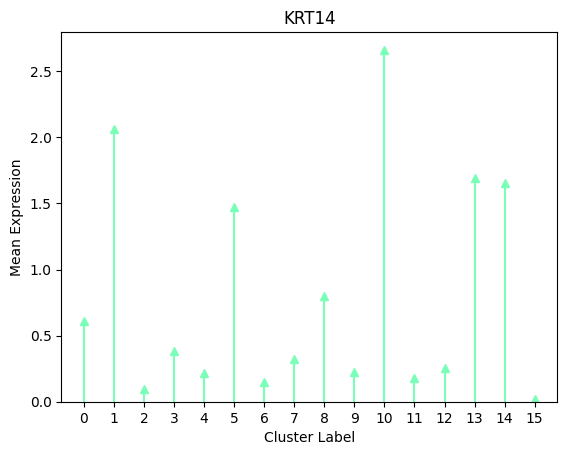

(0.5274509803921568, 0.9990704811844932, 0.6916984393193701, 1.0)


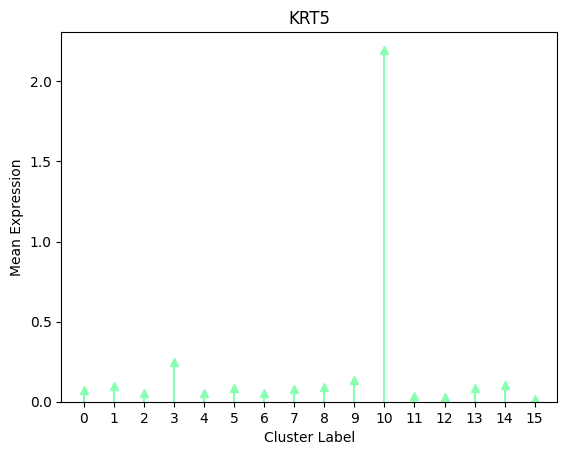

(0.5745098039215686, 0.9931586661366362, 0.6645401787078581, 1.0)


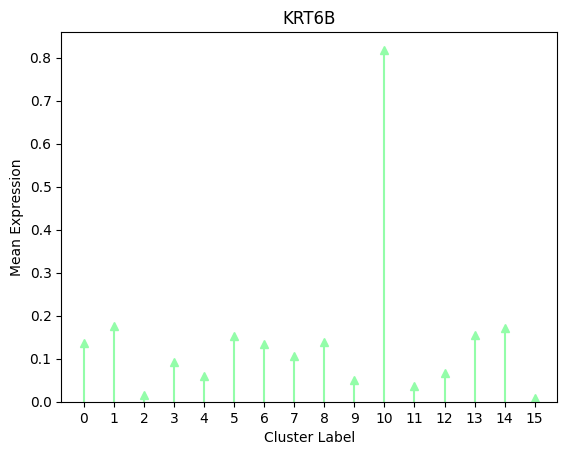

(0.6215686274509804, 0.9818225628535369, 0.6364742361471414, 1.0)


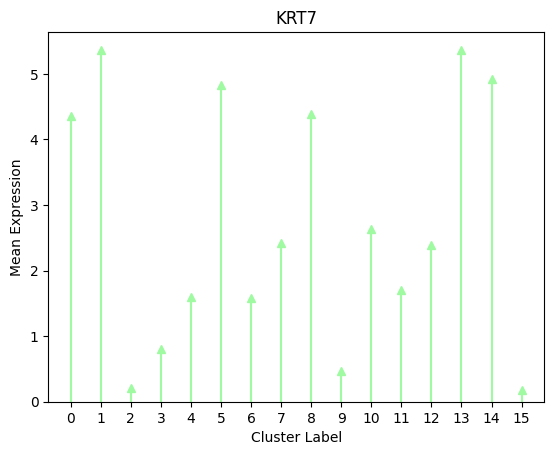

(0.6686274509803922, 0.965124085200289, 0.6075389463388169, 1.0)


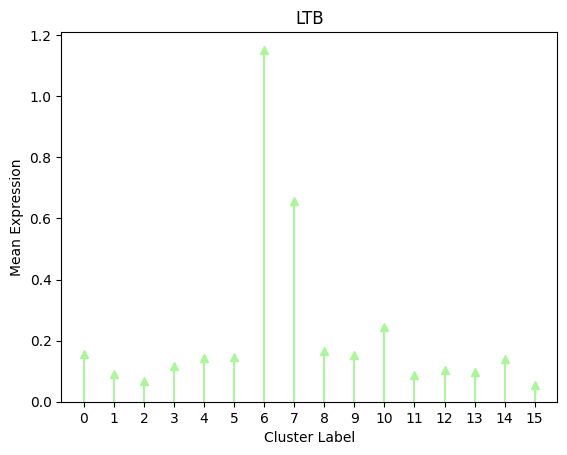

(0.723529411764706, 0.9389883606150565, 0.5727351400805052, 1.0)


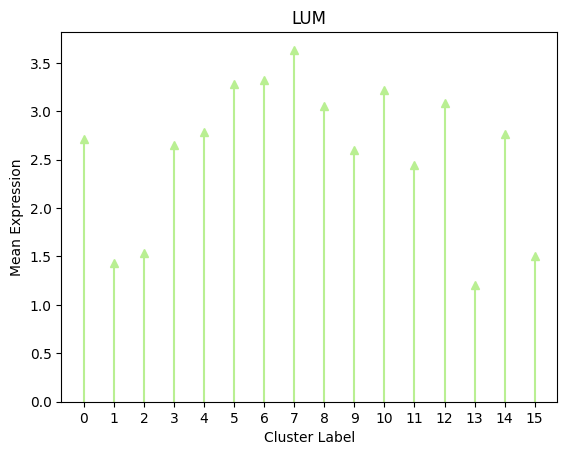

(0.7705882352941176, 0.9110226492460884, 0.5420533564724495, 1.0)


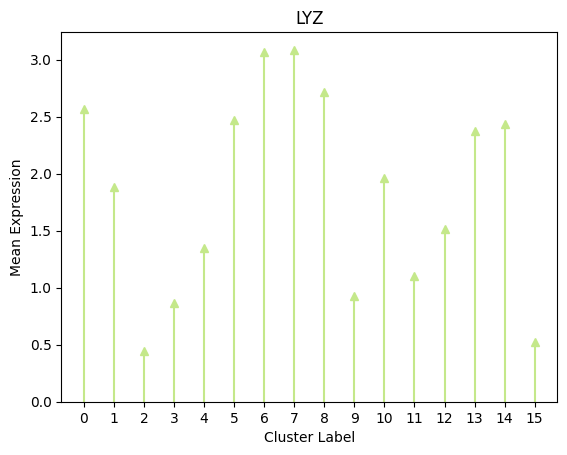

(0.8176470588235294, 0.878081248083698, 0.510631193180907, 1.0)


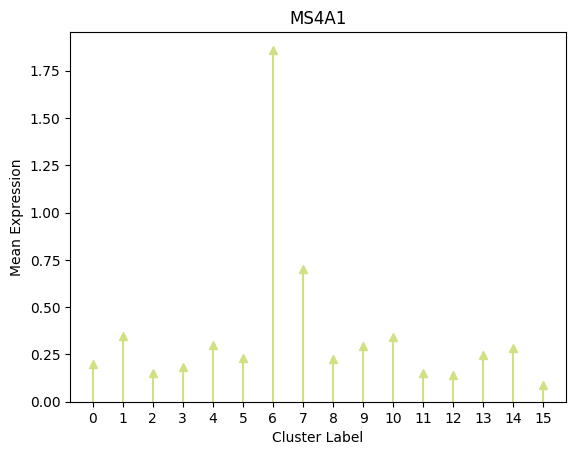

(0.8647058823529412, 0.8403440716378927, 0.4785115691012865, 1.0)


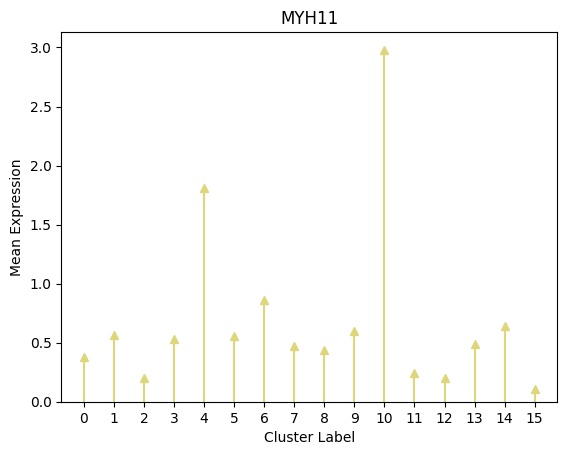

(0.919607843137255, 0.7905324123001635, 0.4402157408309874, 1.0)


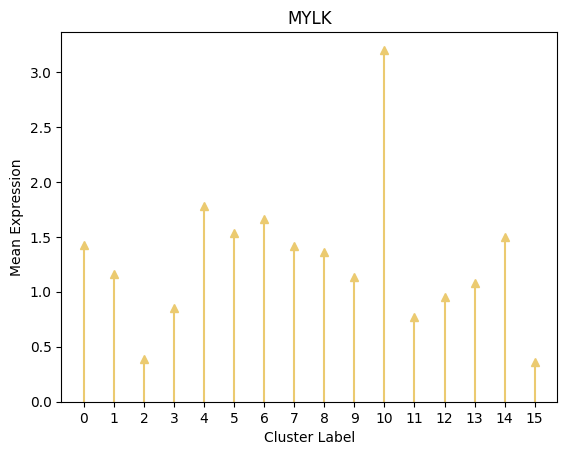

(0.9666666666666666, 0.7431448254773945, 0.4067366430758004, 1.0)


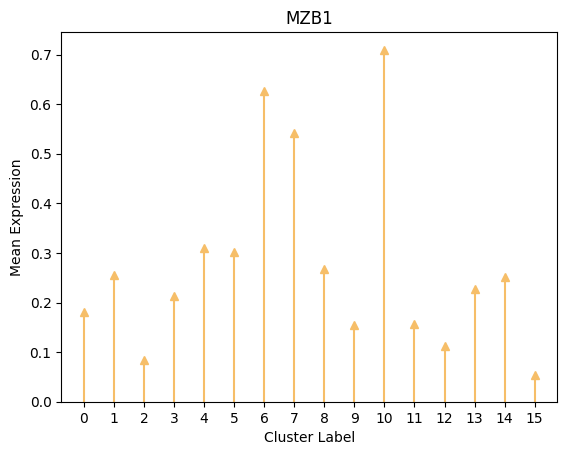

(1.0, 0.6916984393193701, 0.3727019919909141, 1.0)


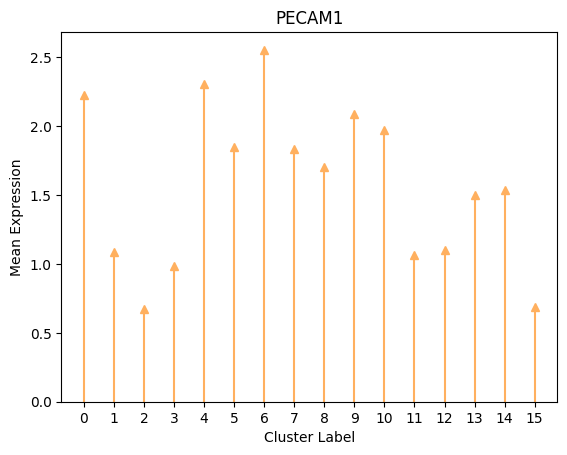

(1.0, 0.6364742361471414, 0.33815827481581706, 1.0)


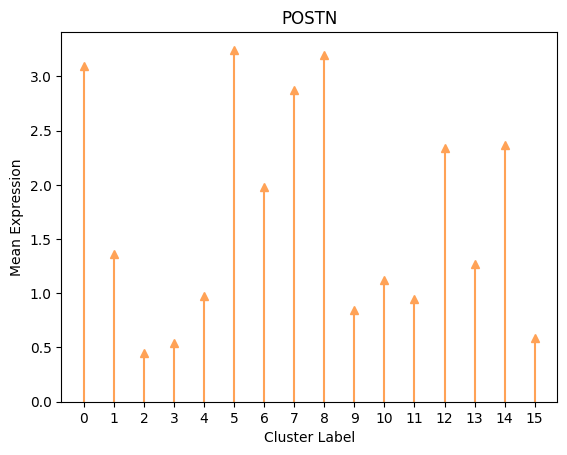

(1.0, 0.5676747161445903, 0.29727685063120274, 1.0)


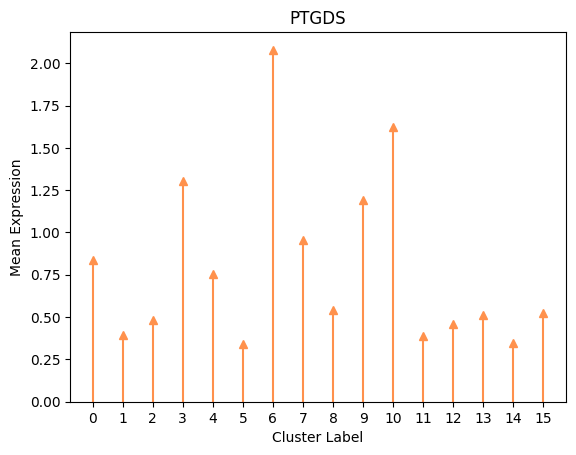

(1.0, 0.5053251839489484, 0.2617928573630405, 1.0)


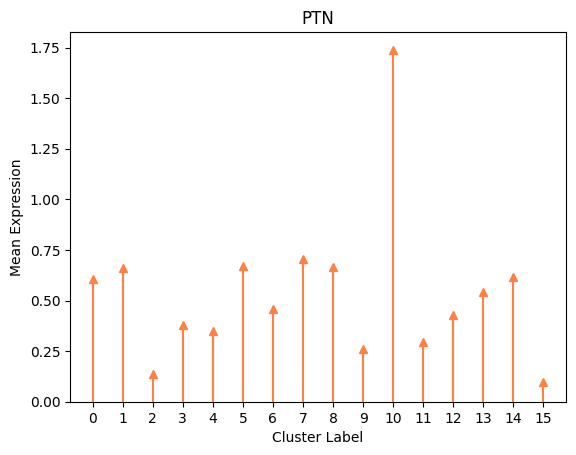

(1.0, 0.44021574083098747, 0.22595128654174773, 1.0)


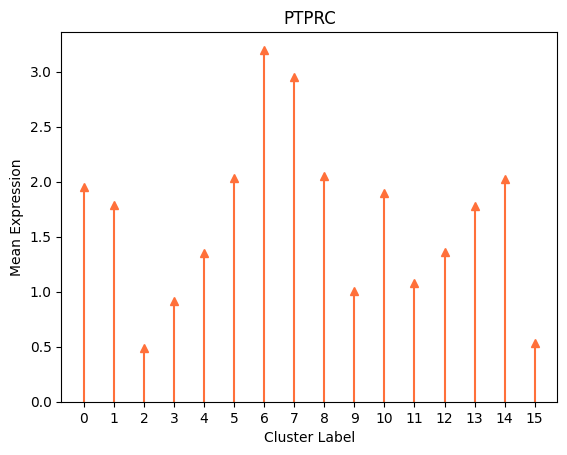

(1.0, 0.37270199199091436, 0.18980109344182594, 1.0)


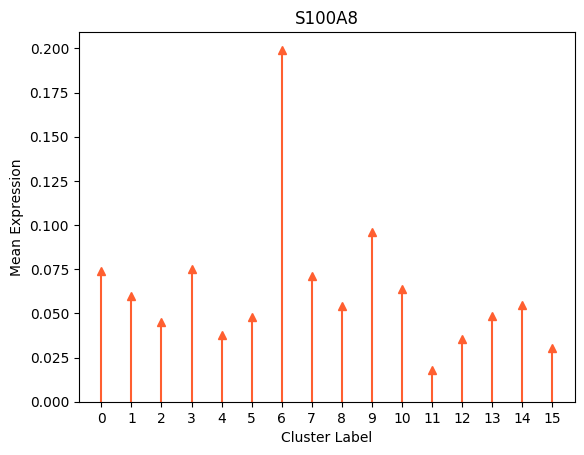

(1.0, 0.2913897468893248, 0.14730169805463758, 1.0)


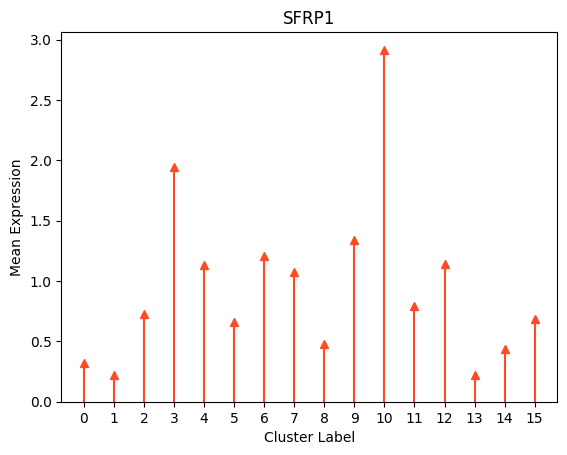

(1.0, 0.21994635783966857, 0.11065268189150082, 1.0)


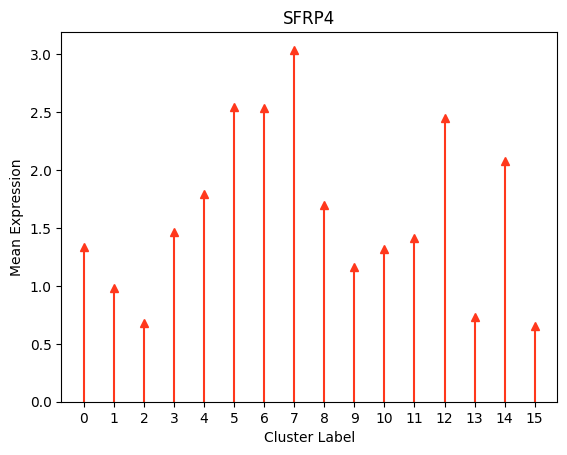

(1.0, 0.14730169805463766, 0.07385252747487403, 1.0)


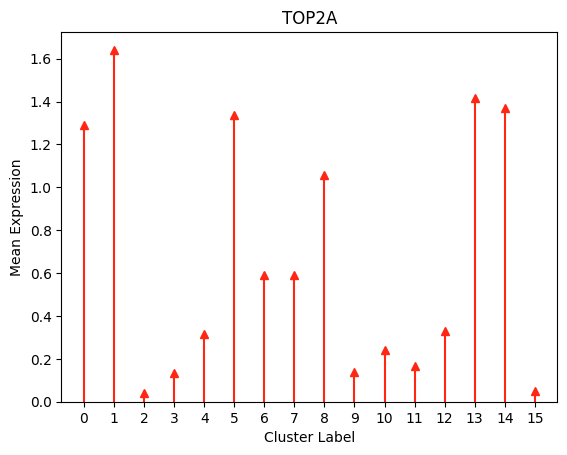

(1.0, 0.07385252747487431, 0.03695149938914507, 1.0)


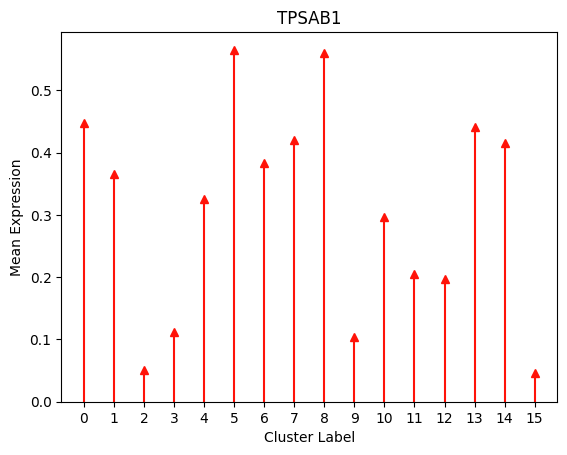

(1.0, 1.2246467991473532e-16, 6.123233995736766e-17, 1.0)


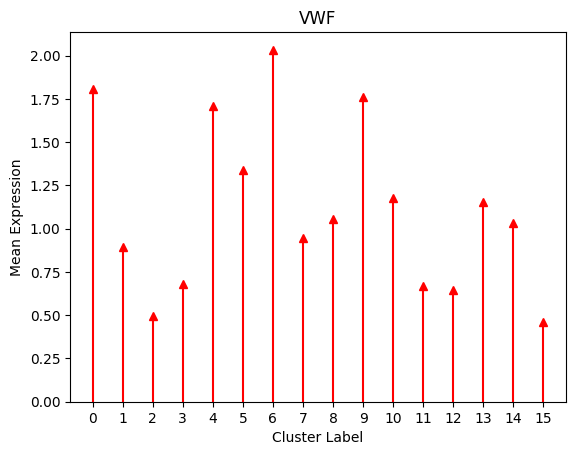

In [55]:
from matplotlib.cm import get_cmap
cmap = get_cmap('rainbow')

for i, gene in enumerate(mean_expression_by_cluster.columns):
    # using subplots() to draw vertical lines 
    fig, axes = plt.subplots() 
    axes.vlines(mean_expression_by_cluster[gene].index, ymin=0, ymax=mean_expression_by_cluster[gene], color=cmap(i / (len(mean_expression_by_cluster.columns) - 1))) 
    
    # drawing the markers (circle) 
    print(cmap(i / (len(mean_expression_by_cluster.columns) - 1)))
    axes.plot(mean_expression_by_cluster[gene].index, mean_expression_by_cluster[gene], "^", c=cmap(i / (len(mean_expression_by_cluster.columns) - 1))) 
    axes.set_ylim(0) 
    
    # formatting and details 
    plt.xlabel('Cluster Label') 
    plt.ylabel('Mean Expression') 
    plt.title(gene) 
    plt.xticks(mean_expression_by_cluster[gene].index) 
    plt.show()

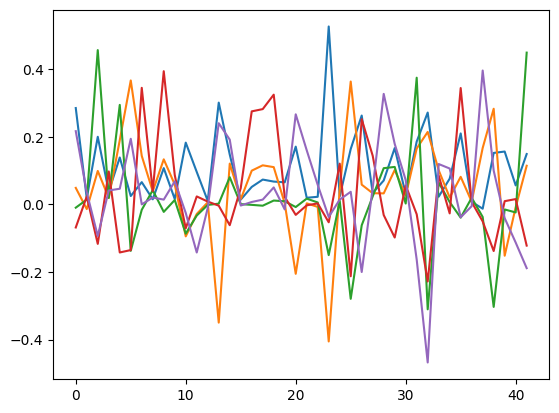

In [39]:
plt.plot(clustering.xenium_spot_data.varm["PCs"])